# SYSNet: Systematics Treatment with Neural Networks

`SYSNet` was developed to tackle the problem of imaging systematic effects, e.g., Galactic dust, in galaxy survey data.

## 1. Installation

### 1.1 Anaconda Python

We recommend Conda for installing the required packages. First, you need to make sure you have Conda installed or updated in your system. Use the commandd `$> which conda` to see if conda is installed in the system. If not, please follow the instructions given at https://docs.conda.io/projects/conda/en/latest/index.html (or https://docs.conda.io/en/latest/miniconda.html#linux-installers for linux). For instance, I would execute the following commands on Linux:  
```bash
    wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
    sha256sum Miniconda3-latest-Linux-x86_64.sh
```

### 1.2 Pytorch

Next, we create an environment (e.g., called `sysnet`) and install Pytorch. We recommend to take a look at the [Pytorch website](https://render.githubusercontent.com/view/pytorch.org) to learn more about the framework. The installation of Pytorch on GPU-available machines is different from CPU-only. For instance, to set up on the Ohio State Cluster (OSC), you should execute the next two commands to load the CUDA library: 
```bash
    module spider cuda # on OSC
    module load cuda/10.1.168 # on OSC
```
*Note* that for other supercomputers, e.g., NERSC, you may have to read the appropriate NERSC documentation to see how you can load the CUDA library. For all other devices, i.e., CPU only, you can skip these steps. Then,
```bash
    conda create -q -n sysnet python=3.8 scikit-learn git jupyter ipykernel ipython mpi4py matplotlib
    conda activate sysnet
    conda install pytorch torchvision -c pytorch  # see below for a GPU-enabled installation
    conda install -c conda-forge fitsio healpy absl-py pytables pyyaml
```
For a GPU-enabled installation (e.g., on OSC), we should execute this command instead (see https://www.osc.edu/resources/available_software/software_list/cuda & https://www.osc.edu/supercomputing/batch-processing-at-osc/monitoring-and-managing-your-job):  
```bash
    conda install pytorch torchvision cudatoolkit=10.1 -c pytorch # on OSC
```

### 1.3 Download and Path (PYTHONPATH) Setup
Finally, we clone (or download) the sysnetdev repository from Github using `git clone https://github.com/mehdirezaie/sysnetdev.git` and add the sysnetdev directory path to the PYTHONPATH variable:

`export PYTHONPATH=\path\to\sysnetdev:$PYTHONPATH`, you need to replace `\path\to\sysnetdev` with the path to sysnetdev in your system. Then, execute the following command in the terminal to add the sysnet kernel to your Jupyter notebook:
```bash
  python -m ipykernel install --user --name=sysnet --display-name "python (sysnet)"
```
In order to test if the installation went correctly. Navigate to the _scripts_ directory, and run the script _app.py_ with `python app.py`. If everything goes smoothly, it means you have installed the package successfully.

## 2. Summary
In general, the process can be separated into three steps: _preprocessing_ (e.g., tabulated data preparation), _regression_, and _post processing_ (e.g., weight assignment). In this notebook, we only focus on the regression process.
#### 2.1 Preprocessing
The input data to `SYSNet` is a tabulated data of the following fields:
1. `hpix`: (int) HEALPix index
2. `label`: (float) number count of galaxies (or quasars) in pixel
3. `fracgood`: (float) weight associated to pixel (the network output will be multiplied by this factor)
4. `features`: (float) array holding imaging properties for pixel

#### 2.2 Neural Network regression
The `SYSNet` software is called in this step to perform a regression analysis modeling the relationship between `label` and `features`.

#### 2.3 Postprocessing
The `SYSNet` output will be used to assign appropriate _weights_ to galaxies to account for observational systematics.

## 3. Regression

### 3.1 Read input data
In the following, we aim to provide a demo of the regression and postprocessing steps.

columns in `input`: [('features', '>f8', (9,)), ('label', '>f8'), ('fracgood', '>f8'), ('hpix', '>i8')]
(381896,) (381896,) (381896, 9)


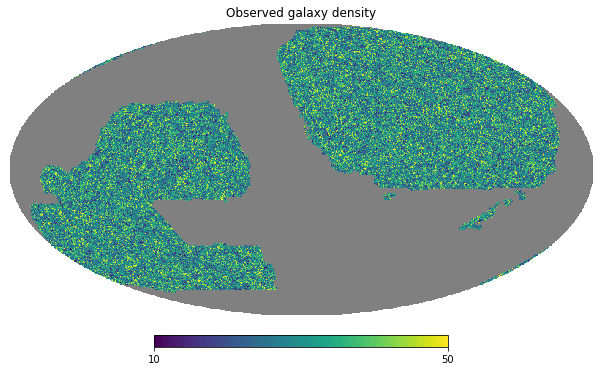

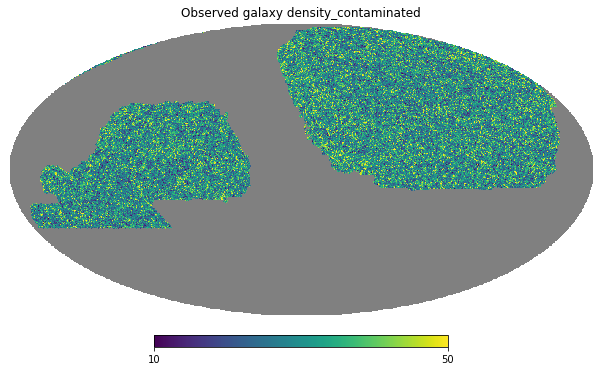

In [196]:
#
# importing general Python modules
#
import os
import sys 
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft
from pathlib import Path

# 
# importing SYSNET modules
# add the absolute path to 'sysnetdev'
sys.path.append('/home/jayashreeb/Documents/sysnet/sysnetdev')

from sysnet import SYSNet, Config, TrainedModel
%matplotlib inline

# tabulated catalog that contains, imaging properties (features), galaxy counts (label), 
# HEALPix index (hpix), and pixel completeness (fracgood)

input1_path = '/mnt/data1/lognormal/0.57.0/nlrg_features_desi_256.fits'
input2_path = '/mnt/data1/lognormal/hpmaps/lrghp-zero-1-f1z1.fits'
input2_cpath = '/mnt/data1/lognormal/hpmaps/lrghp-czero-1-f1z1.fits'

input1 = ft.read(input1_path)  # read tab. data
print(f'columns in `input`: {input1.dtype}')
  
print(np.shape(input1["label"]),np.shape(input1["hpix"]),np.shape(input1["features"]))

input2 = hp.read_map(input2_path) # read hpmaps. data
input2_c = hp.read_map(input2_cpath) # read hpmaps. data

mask = np.zeros(12*nside*nside)
mask[input1['hpix']] = True
input2[np.logical_not(mask)] = hp.UNSEEN
input2_c[np.logical_not(mask)] = hp.UNSEEN

# repackage hpix and label to a HEALPix map for visualization purpose    
nside = 256
ng = np.zeros(12*nside*nside)
ng[:] = np.nan
ng_c = ng.copy()

ng[input1['hpix']] = input2[input1['hpix']]

# Mollweide projection
hp.mollview(ng, rot=-85, min=10, max=50,
            title='Observed galaxy density');

ng_c[input1['hpix']] = input2_c[input1['hpix']]
hp.mollview(ng_c, rot=-85, min=10, max=50,
            title='Observed galaxy density_contaminated');

In [197]:
ng[input1['hpix']] - ng_c[input1['hpix']]

array([-3.12979458e+00, -3.00057212e+00, -3.85604955e+00, ...,
        1.63750000e+30,  1.63750000e+30,  1.63750000e+30])

SYSNet takes its input variables from a config file, `config.yaml`.

In [205]:
config = Config('../scripts/config.yaml')
config.__dict__

{'input_path': '../input/eBOSS.ELG.NGC.DR7.table.fits',
 'output_path': '../output/model_test',
 'restore_model': None,
 'batch_size': 512,
 'nepochs': 2,
 'nchains': 1,
 'find_lr': False,
 'find_structure': False,
 'find_l1': False,
 'do_kfold': False,
 'do_tar': False,
 'snapshot_ensemble': False,
 'normalization': 'z-score',
 'model': 'dnnp',
 'optim': 'adamw',
 'scheduler': 'cosann',
 'axes': [0, 1, 2],
 'do_rfe': False,
 'eta_min': 1e-05,
 'learning_rate': 0.001,
 'nn_structure': [4, 20],
 'l1_alpha': -1.0,
 'loss': 'pnll',
 'no_eval': False}

### 3.2. Finding the optimal learning rate

In [209]:
# let's update some input arguments
config.update('input_path',[input1_path,input2_path])
config.update('output_path', "../output/"+ Path(input1_path).stem + "/zero/zero1_l1")
config.update('nepochs', 30) #actual value=150, trial value=30. See loss vs epoch plot dor optimum value
config.update('axes',[1, 3, 5, 7, 8]) # num of features for this dataset [i for i in range(9)]
config.update('batch_size', 4096)
config.update('learning_rate', 0.007) #desi:zero:0.007,czero:0.05
config.update('nchains', 20)
config.update('do_kfold', True)
#config.update('l1_alpha',0.01 ) #desi:0.01

config.__dict__

# run learning rate finder
# config.update('find_l1', True)
# config.update('find_lr', True)

# pipeline = SYSNet(config) # perform regression
# pipeline.run()

{'input_path': ['/mnt/data1/lognormal/0.57.0/nlrg_features_desi_256.fits',
  '/mnt/data1/lognormal/hpmaps/lrghp-zero-1-f1z1.fits'],
 'output_path': '../output/nlrg_features_desi_256/zero/zero1_l1',
 'restore_model': None,
 'batch_size': 4096,
 'nepochs': 30,
 'nchains': 20,
 'find_lr': False,
 'find_structure': False,
 'find_l1': False,
 'do_kfold': True,
 'do_tar': False,
 'snapshot_ensemble': False,
 'normalization': 'z-score',
 'model': 'dnnp',
 'optim': 'adamw',
 'scheduler': 'cosann',
 'axes': [1, 3, 5, 7, 8],
 'do_rfe': False,
 'eta_min': 1e-05,
 'learning_rate': 0.007,
 'nn_structure': [4, 20],
 'l1_alpha': -1.0,
 'loss': 'pnll',
 'no_eval': False,
 'loss_kwargs': {'log_input': False, 'reduction': 'none'},
 'optim_kwargs': {'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0.0,
  'amsgrad': False},
 'scheduler_kwargs': {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2},
 'device': device(type='cpu')}

From the plot, we see that for a learning rate around 0.01 the variations in loss is maximized. Therefore, we set the learning rate to 0.01 and train the network.

In [210]:
# let's re-train the network with the best learning rate and l1 alpha
# monitor validation loss
#config.update('find_lr', False) # remember to turn this off
#config.update('learning_rate', 0.02)
#config.update('find_l1',False)

pipeline = SYSNet(config) # perform regression
pipeline.run()

logging in ../output/nlrg_features_desi_256/zero/zero1_l1/train.log
# --- inputs params ---
input_path: ['/mnt/data1/lognormal/0.57.0/nlrg_features_desi_256.fits', '/mnt/data1/lognormal/hpmaps/lrghp-zero-1-f1z1.fits']
output_path: ../output/nlrg_features_desi_256/zero/zero1_l1
restore_model: None
batch_size: 4096
nepochs: 30
nchains: 20
find_lr: False
find_structure: False
find_l1: False
do_kfold: True
do_tar: False
snapshot_ensemble: False
normalization: z-score
model: dnnp
optim: adamw
scheduler: cosann
axes: [1, 3, 5, 7, 8]
do_rfe: False
eta_min: 1e-05
learning_rate: 0.007
nn_structure: [4, 20]
l1_alpha: -1.0
loss: pnll
no_eval: False
loss_kwargs: {'log_input': False, 'reduction': 'none'}
optim_kwargs: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0, 'amsgrad': False}
scheduler_kwargs: {'eta_min': 1e-05, 'T_0': 10, 'T_mult': 2}
device: cpu
pipeline initialized in 0.030 s
 min n max label: [ 4. 88.]
# of data: 381896
data loaded in 0.365 sec
# running pipeline ...
# trainin

KeyboardInterrupt: 

The code outputs several files:
1. `nn-weights.fits`: this file has healpix index and predicted galaxy count
2. `metrics.npz`: training, validation, test loss
3. `best.pth.tar`: the best model parameters

Load the trained model. You should know the name of the model and its architecture (i.e., the number of input features, hidden layers, and hidden layer units).

### 3.3 Propagating through a trained model
In this section, we read the imaging features and load the best trained model. Then we propagate imaging features through the model to get the predicted galaxy counts. Note that the name of the neural network (`name_model`), its structure (`nnstruct`), and the number of features (`num_features`) should match what was used during training.

In [163]:
name_model = 'dnnp'
path_model = '../output/zero1/model_0_2664486226/best.pth.tar'
kw_model = dict(nnstruct=(4, 20), num_features=9)

tm = TrainedModel(name_model, path_model, **kw_model)

Also, the indices for the imaging features that were used in training should be provided via `axes`.

In [164]:
axes = [i for i in range(9)]  # all 18 imaging features used for training
hpix, npred = tm.forward(input1_path, axes=axes) 

ng_ = np.zeros(12*256*256)
ng_[:] = np.nan
ng_[hpix] = npred

/home/jayashreeb/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/jayashreeb/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/jayashreeb/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying t

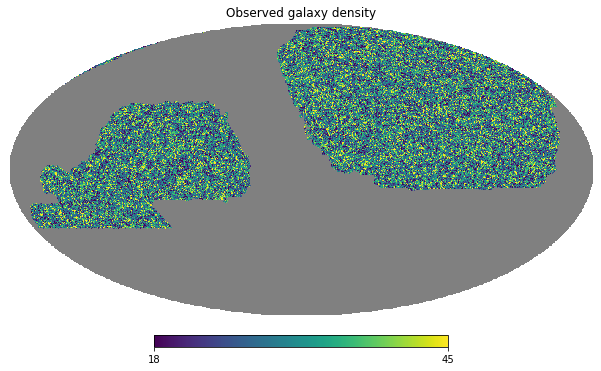

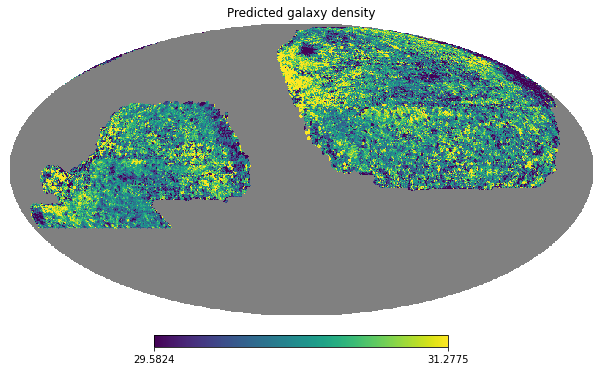

In [165]:
vmin, vmax = np.percentile(ng[hpix], [5, 95])
hp.mollview(ng, rot=-85, min=vmin, max=vmax,
            title='Observed galaxy density')

vmin, vmax = np.percentile(ng_[hpix], [5, 95])
hp.mollview(ng_, rot=-85, min=vmin, max=vmax,
            title='Predicted galaxy density')

In [21]:
hp.write_map('../output/zero1/model_0_2664486226/selection.fits', ng_, 
             dtype='float64', fits_IDL=False, overwrite=True)

For 300 training epochs, a single fold, and a single chain model, this is not a bad result. In practice, we use 5-fold validation (`do_kfold=True`) and train 20 chains (`nchains=20`) for 70-300 epochs.

If you have any questions, feel free to email me at mr095415@ohio.edu.